In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf

In [3]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [4]:
def cubic_basis(x,knots):
    def _cubic_basis(z):
        f=((z-0.5)**2-1.0/12)*((x-0.5)**2-1.0/12)/4.0
        f=f-((tf.abs(x-z)-1.0/2)**4 -0.5*(tf.abs(x-z)-1.0/2)**2+7.0/240)/24.0
        return f
    return tf.transpose(tf.map_fn(_cubic_basis,knots))
def cubic_basis2(x,knots):
    def _cubic_basis(z):
        f=((z-0.5)**2-1.0/12)*((x-0.5)**2-1.0/12)/4.0
        f=f-((np.abs(x-z)-1.0/2)**4 -0.5*(np.abs(x-z)-1.0/2)**2+7.0/240)/24.0
        return f
    return np.array([_cubic_basis(u) for u in knots],np.float32).T

In [5]:
knots=np.array([1.0/6,0.5,5.0/6],dtype=np.float32)
knots2=np.arange(0,1,0.1,dtype=float32)[1:]

In [6]:
batchsize=32

In [7]:
x1=tf.placeholder(dtype=tf.float32,shape=[batchsize,])
x2=tf.placeholder(dtype=tf.float32,shape=[batchsize,])
x3=tf.placeholder(dtype=tf.float32,shape=[batchsize,])
y=tf.placeholder(dtype=tf.float32,shape=[batchsize,])

In [8]:
from tensorflow.python.ops import array_ops


In [9]:
def kronecker_product(mat1, mat2):
  """Computes the Kronecker product two matrices."""
  m1, n1 = mat1.get_shape().as_list()
  mat1_rsh = array_ops.reshape(mat1, [m1, 1, n1, 1])
  m2, n2 = mat2.get_shape().as_list()
  mat2_rsh = array_ops.reshape(mat2, [1, m2, 1, n2])
  return array_ops.reshape(mat1_rsh * mat2_rsh, [m1 * m2, n1 * n2])
def kronecker_product2(mat1, mat2):
  """Computes the Kronecker product two matrices."""
  m1, n1 = mat1.shape
  mat1_rsh = np.reshape(mat1, [m1, 1, n1, 1])
  m2, n2 = mat2.shape
  mat2_rsh = np.reshape(mat2, [1, m2, 1, n2])
  return np.reshape(mat1_rsh * mat2_rsh, [m1 * m2, n1 * n2])

In [10]:
#make_X(x1,knots)

In [11]:
def make_X(x,knots):
    a=cubic_basis(x,knots)
    a0=tf.reshape(tf.ones_like(x), [-1,1])
    a1=tf.reshape(x, [-1,1])
    return tf.concat([a0,a1,a],axis=-1)
def make_S(knots):
    S=np.zeros(shape=[len(knots)+2]*2, dtype=np.float32)
    Y=cubic_basis2(knots,knots)
    Y=Y/np.sum(np.abs(Y))
    S[2:,2:]=Y
    return S
def make_inv_gamma(knots):
    n=len(knots)
    x=(np.arange(n+2)/float(n+2))[1:-1]
    G=cubic_basis2(x,knots).T
    G=np.linalg.pinv(G)
    return G/np.sum(np.abs(G))
    
def make_tp(xlist,knots_lst):
    assert len(xlist)==len(knots_lst)
    Xlist=[make_X(xlist[j],knots_lst[j]) for j in  range(len(xlist))]
    X=[]
    for i in range(batchsize):
        A=[tf.reshape(u[i],[1,-1]) for u in Xlist]
        #print [u.shape for u in A]
        #print A
        X.append(reduce(lambda u,v: kronecker_product(u,v), A))
    X=tf.concat(X,0)
    Slist=[]
    Ilst=[np.eye(len(knots)+2) for knots in knots_lst]
    for i in range(len(knots_lst)):
        knots=knots_lst[i]
        inv_gamma=make_inv_gamma(knots)
        S=make_S(knots)
        s2=np.matmul(np.matmul(inv_gamma.T,S[2:,2:]),inv_gamma)
        s2= s2/np.sum(np.abs(s2))
        S[2:,2:]=s2
        this_Ilist=list(Ilst)
        this_Ilist[i]=S
        S=reduce(lambda u,v: kronecker_product2(u,v), this_Ilist)
        Slist.append(S.astype(np.float32))
    return X,Slist


In [12]:
u,v=make_tp([x1,x2], [knots,knots2])
u,v[0].shape,v[1].shape

(<tf.Tensor 'concat_2:0' shape=(32, 55) dtype=float32>, (55, 55), (55, 55))

In [13]:
def do_shuffle(X,y):
    idx = np.random.permutation(range(len(X)))
    return X[idx], y[idx]

In [63]:
class TsItem(object):
    def __init__(self,name,xlist,batchsize, knots_list, smooth):
        assert len(xlist)==len(knots_list)
        if isinstance(smooth, (int, long)):
            smooth=np.array([smooth]*xsize,np.float32)
        else:
            assert len(smooth)==len(xlist)
        for knots in knots_list:
            assert np.max(knots)<1 and np.min(knots)>0
        self.name=name
        self.smooth=smooth      
        self.batchsize=batchsize
        self.xlist=xlist
        self.knots_list=knots_list
        self.make_model()
    
    def make_model(self):
        smooth=self.smooth
        batchsize=self.batchsize
        if 1: 
            xlist=self.xlist
            self.var_X,self.Slist=make_tp(xlist,self.knots_list)
            self.n=int(self.var_X.get_shape()[1])
            self.beta= tf.Variable(tf.random_normal([self.n,1]),
                          name=self.name)

            #self.X=tf.stack(xlist,axis=1)
            sum_S= 0
            for i in range(len(smooth)):
                sum_S=smooth[i]*self.Slist[i]
            self.sum_S=tf.constant(sum_S,tf.float32)
            self.prediction=tf.matmul(self.var_X, self.beta)
            self.loss2=tf.reduce_sum(tf.matmul(tf.matmul(tf.transpose(self.beta),self.sum_S),self.beta))

In [95]:
class CubicSpline(object):
    def __init__(self,xsize,batchsize, knots_list, smooth=0, losstype=0):
        assert xsize==len(knots_list)
        if isinstance(smooth, (int, long)):
            smooth=np.array([smooth]*xsize,np.float32)
        else:
            assert len(smooth)==xsize
        for knots in knots_list:
            assert np.max(knots)<1 and np.min(knots)>0
        self.smooth=smooth      
        self.xsize=xsize
        self.batchsize=batchsize
        self.knots_list=knots_list
        self.losstype=losstype
        
        self.make_model()
    
    def make_model(self):
        self.graph = tf.Graph()
        smooth=self.smooth
        losstype=self.losstype
        batchsize=self.batchsize
        with self.graph.as_default(): 
            xlist=[tf.placeholder(dtype=tf.float32,shape=[batchsize,]) for _ in range(self.xsize)]
            y=tf.placeholder(dtype=tf.float32,shape=[batchsize,])
            self.y=y
            self.xlist=xlist

            y=tf.reshape(y,[-1,1])
            
            item=TsItem("beta" ,xlist,batchsize, self.knots_list, smooth=smooth)
                
            self.prediction=item.prediction
            
            if losstype==0:
                self.loss1=tf.reduce_mean(tf.pow((y-self.prediction),2))
            elif  losstype==1:
                self.loss1=tf.reduce_mean(tf.abs(y-self.prediction))
            elif  losstype==2:
                e=tf.abs((y-self.prediction))
                Ie=tf.cast(e<0.4,tf.float32)
                e=Ie*e+(1-Ie)*0.4
                self.loss1=tf.reduce_mean(e)
            self.loss2=item.loss2
            self.loss= self.loss1 + self.loss2

            
          
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    #self.optimizer = tf.train.AdagradOptimizer(0.1)#.minimize(self.loss)
                    self.optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None 
        
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            #config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
    def pad(self,bx):
        if len(bx)<self.batchsize:
            newbx=np.zeros([self.batchsize,bx.shape[1]],dtype=np.float32)
            newbx[:len(bx)]=bx
            return newbx
        else:
            return bx
    def predict(self,X):
            n=int(np.ceil(len(X)/float(self.batchsize)))
            lst=[]
            for i in range(n):
                bx=X[i*batchsize:(i+1)*batchsize]
                bx=self.pad(bx)
                feed_dict ={self.xlist[j]: bx[:,j] for j in range(len(self.xlist))}        
                yhat=self.session.run(self.prediction,feed_dict=feed_dict)
                lst.append(yhat)
            yhat=np.concatenate(lst)[:,0]
            assert len(yhat)>=len(X)
            return yhat[:len(X)]
    def score(self,X,y):
        pred=self.predict(X)
        e=np.abs(pred-y)
        e[e>0.4]=0.4       
        return np.mean(e)
        
    def fit(self, rawX,rawy, n_epoch=10, validXY=None):
        if validXY is not None:
            validX,validy=validXY
        assert(rawX.shape[1]==len(self.xlist))
        self.initialize()
        
        for epoch in range(n_epoch):
            X,y=do_shuffle(rawX,rawy)
            losses=[]
            for i in range(int(len(X)/batchsize)):
                bx,by=X[i*batchsize:(i+1)*batchsize],y[i*batchsize:(i+1)*batchsize]
                feed_dict ={self.xlist[j]: bx[:,j] for j in range(len(self.xlist))}
                feed_dict.update({
                    self.y:by
                })
                _, a, aa = self.session.run([self.train_op, self.loss, self.loss1], 
                                                feed_dict=feed_dict)
                losses.append([a,aa])
            if validXY is not None:
                validloss=self.score(validX,validy)
            else:
                validloss=None
            print "Epoch {}, valid loss={}, train loss={}".format(epoch,validloss, np.mean(losses,0))
            

        

In [96]:
if 1:
    tf.reset_default_graph()

In [97]:
a=CubicSpline(2,batchsize, [knots,knots2],[1,1],losstype=1)

In [71]:
X=np.random.random([1000,2])
y=(X[:,0]-0.5)**3+3*X[:,0]*X[:,1]+X[:,1]**2+X[:,1]+np.random.normal(size=[1000,],scale=0.1)
X2=np.random.random([100,2])
y2=(X2[:,0]-0.5)**3+3*X2[:,0]*X2[:,1]+X2[:,1]**2+X2[:,1]+np.random.normal(size=[len(X2),],scale=0.1)

In [72]:
y.shape

(1000,)

In [98]:
a.fit(X,y,200,validXY=(X2,y2))

Epoch 0, valid loss=0.36894910759, train loss=[2.9488626 2.37104  ]
Epoch 1, valid loss=0.358259938519, train loss=[1.9665635 1.806582 ]
Epoch 2, valid loss=0.356184391287, train loss=[1.4512991 1.408161 ]
Epoch 3, valid loss=0.356729128655, train loss=[1.1524293 1.1387489]
Epoch 4, valid loss=0.364526597881, train loss=[0.9893972 0.981281 ]
Epoch 5, valid loss=0.355656533187, train loss=[0.8917459 0.8847405]
Epoch 6, valid loss=0.345383924601, train loss=[0.826574   0.82010585]
Epoch 7, valid loss=0.338565921682, train loss=[0.7655834  0.75952446]
Epoch 8, valid loss=0.333649859317, train loss=[0.7035458  0.69782126]
Epoch 9, valid loss=0.327800098005, train loss=[0.6408605  0.63541895]
Epoch 10, valid loss=0.319977716226, train loss=[0.5722835  0.56708807]
Epoch 11, valid loss=0.304918162328, train loss=[0.5031393 0.498166 ]
Epoch 12, valid loss=0.28244216614, train loss=[0.43283665 0.42806995]
Epoch 13, valid loss=0.248916360421, train loss=[0.36188492 0.357312  ]
Epoch 14, valid lo

Epoch 114, valid loss=0.0884211404768, train loss=[0.08731769 0.08701654]
Epoch 115, valid loss=0.0946365162741, train loss=[0.0879375  0.08763807]
Epoch 116, valid loss=0.0901985735113, train loss=[0.08758595 0.0872919 ]
Epoch 117, valid loss=0.0880934984942, train loss=[0.08755455 0.08726384]
Epoch 118, valid loss=0.0880622549013, train loss=[0.08799761 0.08770921]
Epoch 119, valid loss=0.0949113275613, train loss=[0.08751883 0.08723237]
Epoch 120, valid loss=0.0876623478492, train loss=[0.08771857 0.08743516]
Epoch 121, valid loss=0.0880781534086, train loss=[0.08677753 0.0864962 ]
Epoch 122, valid loss=0.0905295169077, train loss=[0.0870904  0.08681355]
Epoch 123, valid loss=0.0882898988991, train loss=[0.08705058 0.08677603]
Epoch 124, valid loss=0.0893048326744, train loss=[0.08786733 0.08759371]
Epoch 125, valid loss=0.087392553332, train loss=[0.08768389 0.08741456]
Epoch 126, valid loss=0.0915709699323, train loss=[0.08692589 0.0866601 ]
Epoch 127, valid loss=0.091310243736, t

In [103]:
pred=a.predict(X)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


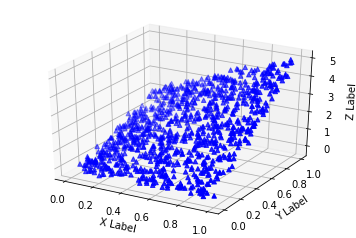

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = X[:,0]
ys = X[:,1]
zs = y
ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [93]:
with tf.Session() as sess:
    b=sess.run(X,{x:np.arange(0,1,0.01)})

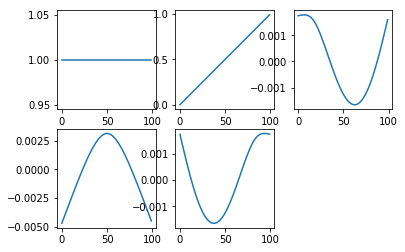

In [99]:
for i, u in enumerate(b.T):
    plt.subplot(2, 3, i+1)
    plt.plot(u)#;plt.show()